# Excise and Repaint: A Tutorial

This notebook serves as an example of the excise and repaint crystal generator.
This tutorial follows the repaint tutorial, many concepts will be reused.

We will take a 2 dimensional system, choose an atom in that system, excise it with the atoms close to it, then use the "analytical model" to generate new samples conditioned on those excised atoms.

In [1]:
import warnings

# To suppress warnings for clearer output
warnings.simplefilter("ignore")

In [2]:
# Define the directory where artifacts will be written. Delete it if it exists to start clean.
import shutil
from diffusion_for_multi_scale_molecular_dynamics import TOP_DIR

output_path = TOP_DIR / "tutorials" / "output" / "tutorial_excise_and_repaint"
if output_path.is_dir():
    shutil.rmtree(output_path)

output_path.mkdir(parents=True, exist_ok=True)

# The effective dataset and analytical model
The excise and repaint module requires a diffusion model for the repainting component. For this, we will consider the same dataset and model as the repaint tutorial. We refer to that tutorial for a better explanation of that part of the code.

We will consider a regular 2D grid as the equilibrium positions. The effective dataset will be distributed like a simple isotropic Gaussian centered on this 2D grid with an effective width sigma_d.

In [3]:
from diffusion_for_multi_scale_molecular_dynamics.models.score_networks.analytical_score_network import \
    AnalyticalScoreNetworkParameters, AnalyticalScoreNetwork
from utilities import get_2d_grid_equilibrium_relative_coordinates


# Define the regular grid that represents the equilibrium relative coordinates
n = 4

# Define the Gaussian width of the effective dataset.
sigma_d = 0.02

equilibrium_relative_coordinates = get_2d_grid_equilibrium_relative_coordinates(n=n)
number_of_atoms = len(equilibrium_relative_coordinates)
spatial_dimension = 2

score_network_parameters = AnalyticalScoreNetworkParameters(number_of_atoms=number_of_atoms,
                                                                spatial_dimension=spatial_dimension,
                                                                num_atom_types=1,
                                                                kmax=4,
                                                                equilibrium_relative_coordinates=equilibrium_relative_coordinates,
                                                                sigma_d=sigma_d)

axl_network = AnalyticalScoreNetwork(score_network_parameters)

# Sampling
Additionally, we need to define sampling parameters. The generator (creating AXL samples using a diffusion model) is managed by the excise and repaint module. We need to specify how that generator operates (defining its parameters).

In [4]:
from diffusion_for_multi_scale_molecular_dynamics.noise_schedulers.noise_parameters import NoiseParameters
from diffusion_for_multi_scale_molecular_dynamics.generators.predictor_corrector_axl_generator import \
    PredictorCorrectorSamplingParameters



# We must define the parameters of this noising process.
noise_parameters = NoiseParameters(total_time_steps=25,
                                   schedule_type="exponential",
                                   sigma_min=0.001,
                                   sigma_max=0.2)


# We will give the cell dimensions to the excise and repaint module so it uses a diffusion model that does not operate
# on the lattice parameters (L is frozen)
cell_dimensions = [1.0, 1.0]

# Define the sampling parameters. We will draw a single sample, and we will record the corresponding trajectory during 
# diffusion to see what it looks like.
sampling_parameters = PredictorCorrectorSamplingParameters(number_of_samples=1,
                                                           spatial_dimension=spatial_dimension,
                                                           number_of_corrector_steps=1,
                                                           num_atom_types=1,
                                                           number_of_atoms=number_of_atoms,
                                                           use_fixed_lattice_parameters=True,
                                                           cell_dimensions=cell_dimensions,
                                                           record_samples=True)

# Excisor

We have to define how we will excise an atom with its environment from the rest of the system. 

For this tutorial, we will use a NearestNeighborsExcision: we will take one atom with its *k*-nearest neighbors and isolate them. We will also extract only 1 such cluster of atoms.

In [5]:
from diffusion_for_multi_scale_molecular_dynamics.active_learning_loop.excisor.nearest_neighbors_excisor import (
    NearestNeighborsExcision, NearestNeighborsExcisionArguments)

excisor_arguments = NearestNeighborsExcisionArguments(
    number_of_neighbors=4,
    excise_top_k_environment=1
)

excisor = NearestNeighborsExcision(excisor_arguments)

# Excise and Repaint Sample Maker

Putting all of these together, we can construct our sample generator. We used the term SampleMaker to distinguish the diffusion generator from this module that creates new structures based on existing atoms.

In [6]:
from diffusion_for_multi_scale_molecular_dynamics.active_learning_loop.sample_maker.excise_and_repaint_sample_maker import \
    ExciseAndRepaintSampleMakerArguments, ExciseAndRepaintSampleMaker

# we will place the atoms in a smaller box of size (0.6, 0.6)
# note that 0.5 is too small (barely)

e_and_r_args = ExciseAndRepaintSampleMakerArguments(
    sample_box_size=[0.6 * x for x in cell_dimensions],  # size of the smaller box in which to repaint
    element_list=["X"],
    sample_box_strategy="fixed",
)

sample_maker = ExciseAndRepaintSampleMaker(
    sample_maker_arguments=e_and_r_args,
    environment_excisor=excisor,
    noise_parameters=noise_parameters,
    sampling_parameters=sampling_parameters,
    diffusion_model=axl_network
)

# Initial sample

The excise and repaint sample maker will generate new samples based on an initial configuration given an uncertainty for each atom. This should be the uncertainties related to a MLIP during a molecular dynamics run.

For this tutorial, we will use a set of atoms near the equilibrium point, with a random uncertainty.

In [7]:
import numpy as np

from diffusion_for_multi_scale_molecular_dynamics.namespace import AXL

np.random.seed(1)
sample_positions = np.array(equilibrium_relative_coordinates) + \
    np.random.random(np.array(equilibrium_relative_coordinates).shape) * sigma_d

initial_sample = AXL(
    A=np.zeros((number_of_atoms,)),
    X=sample_positions,
    L=np.array(cell_dimensions + [0])  # cell_dimensions is a 2D array, we need to add a 3rd value for the angle to get lattice parameters
)

uncertainties = np.random.random((number_of_atoms,))

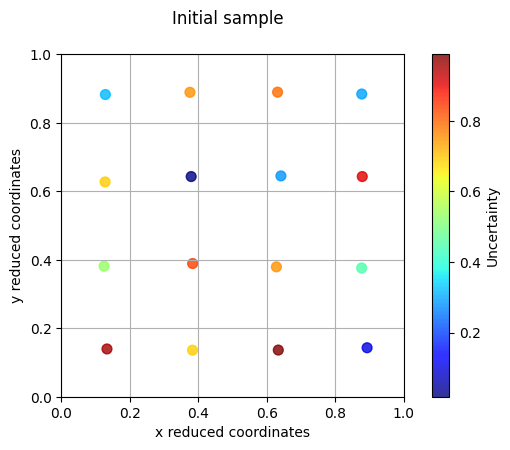

In [8]:
from diffusion_for_multi_scale_molecular_dynamics.analysis import PLEASANT_FIG_SIZE
from matplotlib import pyplot as plt

fig = plt.figure(figsize=PLEASANT_FIG_SIZE)
fig.gca().set_aspect('equal')
fig.suptitle(f"Initial sample")

scatter = plt.scatter(sample_positions[:, 0], sample_positions[:, 1], c=uncertainties, cmap="jet", s=50, alpha=0.8)
plt.colorbar(scatter, label="Uncertainty")
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xlabel("x reduced coordinates")
plt.ylabel("y reduced coordinates")
# we show the grid to see the "noise" on the atoms coordinates
plt.grid(True)
plt.show()

# Making new samples step 1: excision

The sample maker class handles automatically the environment excision and repaint process. We will go through it step by step. 

The first step is to find the problematic environments (high uncertainty) and excise them. For our example, this is the atom with the highest uncertainty (the darker red atom in the plot above). This is done through the sample maker class calling the excisor. The excised atoms are centered such that the one with the high uncertainty is at the center of the unit cell.

In [9]:
constrained_environments_after_excision = sample_maker.environment_excisor.excise_environments(
    initial_sample, uncertainties, center_atoms=True
)

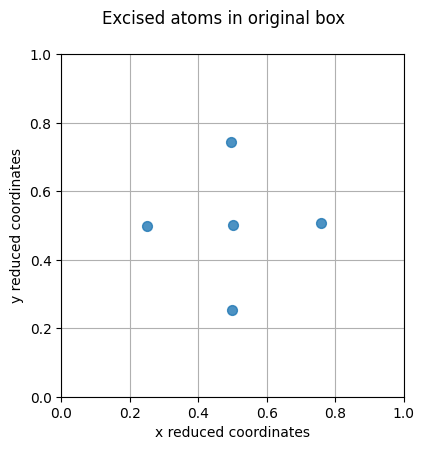

In [15]:
fig = plt.figure(figsize=PLEASANT_FIG_SIZE)
fig.suptitle(f"Excised atoms in original box")

excised_coordinates = constrained_environments_after_excision[0].X
scatter = plt.scatter(excised_coordinates[:, 0], excised_coordinates[:, 1], s=50, alpha=0.8)
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xlabel("x reduced coordinates")
plt.ylabel("y reduced coordinates")
# we show the grid to see the "noise" on the atoms coordinates
plt.grid(True)
fig.gca().set_aspect('equal')

plt.show()

These atoms are then embedded in a smaller box. The size of that box is passed as an argument to *ExciseAndRepaintSampleMakerArguments*. We are using a box of half the size here.

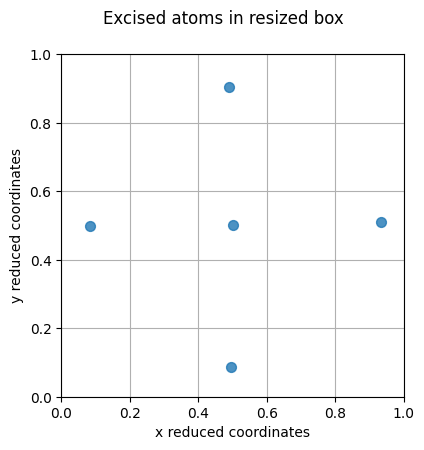

In [16]:
constrained_environment_in_new_box = sample_maker.embed_structure_in_new_box(
    constrained_environments_after_excision[0],
    sample_maker.arguments.new_box_lattice_parameters
)

fig = plt.figure(figsize=PLEASANT_FIG_SIZE)
fig.suptitle(f"Excised atoms in resized box")

excised_coordinates = constrained_environment_in_new_box.X
scatter = plt.scatter(excised_coordinates[:, 0], excised_coordinates[:, 1], s=50, alpha=0.8)
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xlabel("x reduced coordinates")
plt.ylabel("y reduced coordinates")
# we show the grid to see the "noise" on the atoms coordinates
plt.grid(True)
fig.gca().set_aspect('equal')
plt.show()

# Repaint the other atoms

Using these atoms as fixed, we now paint a new structure. Note that we ignore the fact that the box is smaller in the analytical system as the lattice parameters are not used (the model acts only on the reduced coordinates).

In [12]:
new_samples = sample_maker.make_samples_from_constrained_substructure(
   constrained_environment_in_new_box,
   1  # create only 1 new structure
)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 910.74it/s]


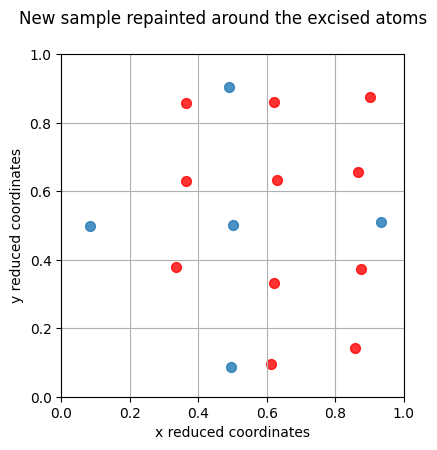

In [17]:
fig = plt.figure(figsize=PLEASANT_FIG_SIZE)
fig.suptitle(f"New sample repainted around the excised atoms")

excised_coordinates = new_samples[0].X
scatter = plt.scatter(excised_coordinates[:5, 0], excised_coordinates[:5, 1], s=50, alpha=0.8)
scatter = plt.scatter(excised_coordinates[5:, 0], excised_coordinates[5:, 1], s=50, alpha=0.8, c="red")

plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xlabel("x reduced coordinates")
plt.ylabel("y reduced coordinates")
# we show the grid to see the "noise" on the atoms coordinates
plt.grid(True)
fig.gca().set_aspect('equal')
plt.show()

The analytical model used is not equivariant to the order of the atoms and is not invariant under translation. It placed the 11 atoms that were movable to the correct coordinates, and the other 5 are frozen at the right place. 
The model also doesn't care about the lattice parameters, so the red balls in reduced coordinates here should match (within a $\sigma_d$) the original sample even though the cartesian coordinates would not match.

# Wrapping up all the operations

The SampleMaker calls all of the previous methods directly, we don't have to do it manually.

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 606.49it/s]


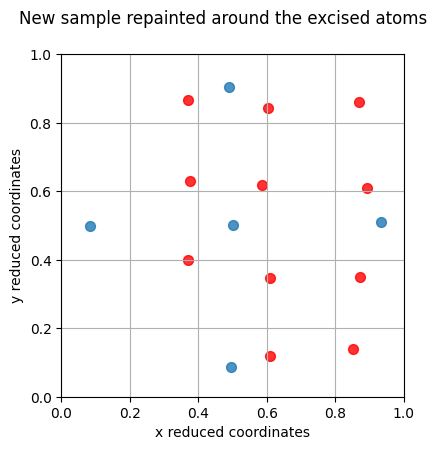

In [18]:
new_samples = sample_maker.make_samples(
    initial_sample, uncertainties
)

fig = plt.figure(figsize=PLEASANT_FIG_SIZE)
fig.suptitle(f"New sample repainted around the excised atoms")

excised_coordinates = new_samples[0].X
scatter = plt.scatter(excised_coordinates[:5, 0], excised_coordinates[:5, 1], s=50, alpha=0.8)
scatter = plt.scatter(excised_coordinates[5:, 0], excised_coordinates[5:, 1], s=50, alpha=0.8, c="red")

plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xlabel("x reduced coordinates")
plt.ylabel("y reduced coordinates")
# we show the grid to see the "noise" on the atoms coordinates
plt.grid(True)
fig.gca().set_aspect('equal')
plt.show()